### Исследование данных сервиса аренды самокатов GoFast.

**Цель работы:** проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Входные данные - данные популярного сервиса аренды самокатов GoFast, содержащие информацию о некоторых пользователях из нескольких городов, а также об их поездках.

**План работы:**
1. открыть и изучить таблицы с данными;
2. провести предобработку данных: избавиться от пустых значений, дубликатов, аномалий, изменить тип данных в столбце `date`, создать новый столбец с номером месяца;
3. произвести исследовательский анализ данных, проверить:
  * частоту встречаемости городов;
  * соотношение пользователей с подпиской и без подписки;
  * возраст пользователей;
  * расстояние, которое пользователь преодолел за одну поездку;
  * продолжительность поездок.
4. объединить данные и создать датафреймы:
  * объединить данные о пользователях, поездках и подписках в один датафрейм;
  * создайте ещё два датафрейма c данными о пользователях без подписки и с подпиской из объединенного датафрейма;
  * визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.
5. подсчитать выручку:
  * создайть датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из прошлого шага;
  * в этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь.
6. проверить гипотезы:
  * тратят ли пользователи с подпиской больше времени на поездки;
  * можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
  * будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки;
  * ответить на вопрос, подобрать тест для проверки представленной гипотизы.
7. построить распределения.

#### Шаг 1. Загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from math import sqrt

In [ ]:
users_df = pd.read_csv('/datasets/users_go.csv')
display(users_df.info())
users_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [ ]:
rides_df = pd.read_csv('/datasets/rides_go.csv')
display(rides_df.info())
rides_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [ ]:
subs_df = pd.read_csv('/datasets/subscriptions_go.csv')
display(subs_df.info())
subs_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод по первому шагу:** открыли и изучили таблицы с данными.

Первый датафрейм, содержащий информацию о пользователях, состоит из 5 столбцов и 1565 строк, тип данных в которых: int64 (2 столбца) и object(3 столбца).

Второй датафрейм, который содержит информацию о поездках, состоит из 4 столбцов и 18068 строк, тип данных в которых: int64 (1 столбец), float64 (2 столбца) и object(1 столбец).

Третий датафрейм с информацией о подписках, состоит из 4 столбцов и всего 2-х строк, тип данных в которых: int64 (3 столбца) и object(1 столбец).

На первый взгляд пропусков в таблицах не видно, а их размеры разнятся из-за особеннойстей содержащихся в них данных. Далее необходимо провести предобработку данных.

#### Шаг 2. Предобработка данных

Приведем столбец `date` таблицы `rides_df` к типу даты pandas.

In [ ]:
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')

Дабавим столбец `month`, который будет содержать номер месяца из столбца `date`.

In [ ]:
rides_df['month'] = rides_df['date'].dt.month
rides_df.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [ ]:
print('Начало периода:', rides_df['date'].min())
print('Конец периода:',rides_df['date'].max())
print('Продолжительность периода:', rides_df['date'].max() - rides_df['date'].min())

Начало периода: 2021-01-01 00:00:00
Конец периода: 2021-12-30 00:00:00
Продолжительность периода: 363 days 00:00:00


Данные представлены с 01.01.2021 по 30.12.2021, промежуток составляет 363 дня, практически весь 2021-й год.

Для экономии памяти заменим 64-х разрядные числовые переменные на 32-х разрядные.

In [ ]:
users_df['user_id'] = users_df['user_id'].astype('int32')
users_df['age'] = users_df['age'].astype('int32')

In [ ]:
rides_df['user_id'] = rides_df['user_id'].astype('int32')
rides_df['distance'] = rides_df['distance'].astype('float32')
rides_df['duration'] = rides_df['duration'].astype('float32')

In [ ]:
subs_df['minute_price'] = subs_df['minute_price'].astype('int32')
subs_df['start_ride_price'] = subs_df['start_ride_price'].astype('int32')
subs_df['subscription_fee'] = subs_df['subscription_fee'].astype('int32')

Судя по данным, полученным из датафреймов методом `info()`, можно сделать вывод, что пропуски в датафреймах отсутствуют. Во всех столбцах кроме `user_id` могут быть повторяющиеся значения, это нормально для представленных данных, поэтому осается проверить столбец `user_id` на наличие дубликатов.

In [ ]:
users_df['user_id'].nunique()

1534

In [ ]:
users_df.duplicated().sum()

31

Столбец `user_id` датафрейма с информацией о пользователях имеет 31 явный дубликат, избавимся от них.

In [ ]:
users_df = users_df.drop_duplicates()

In [ ]:
rides_df.duplicated().sum()

0

In [ ]:
rides_df['user_id'].nunique()

1534

Датафрейм `rides_df` имеет в столбце `user_id` 1534 уникальных значения без дубликатов.

**Вывод по второму шагу:** изменили тип данных в столбце `date`, создали новый столбец с номером месяца. Для экономии памяти заменили 64-х разрядные числовые переменные на 32-х разрядные. Обнаружили, что пропуски в представленных датафреймах отсутствуют. Таблица `users_df` имела 31 явный дубликат, избавились от них, после чего число строк в ней стало равняться 1534. Больше явных дубликатов обнаружено не было, во всех оставшихся колонках первых двух датафреймов повторение значений нормально для представленных данных, мы не можем называть это неявными дубликатами.

#### Шаг 3. Исследовательский анализ данных

* Рассмотрим частоту встречаемости городов из датафрейма `users_df`.

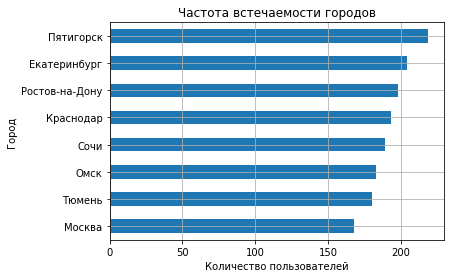

In [ ]:
users_df.groupby('city')['name'].count().sort_values().plot(kind='barh', grid=True)
plt.ylabel('Город')
plt.xlabel('Количество пользователей')
plt.title('Частота встечаемости городов');

Мы видим, что пользователи практически равнромерно распределены по городам. При этом наиболее часто встречается город Пятигорск, наименее часто - Москва.

* Изучим соотеношение пользователей с подпиской и без в датафрейме `users_df`.

Соотношение пользователей с подпиской и без: 1.1945636623748213


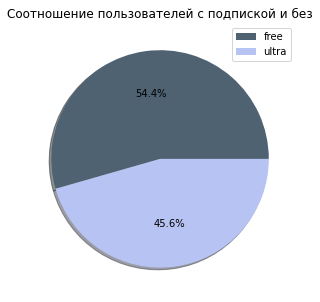

In [ ]:
print('Соотношение пользователей с подпиской и без:', (users_df[users_df['subscription_type'] == 'free'].count() / users_df[users_df['subscription_type'] == 'ultra'].count())[1])
plt.figure(figsize=(5, 5))
plt.pie(users_df.groupby('subscription_type')['name'].count(), colors = ['#4F6272', '#B7C3F3'], autopct='%1.1f%%', shadow=True)
plt.legend(['free', 'ultra'])
plt.title('Соотношение пользователей с подпиской и без');
plt.show();

В результате анализа видим, что количество пользователей без подписки к количеству пользователей с подпиской относится примерно, как 6 к 5. Или от общего числа пользователей 54,4% составляют первые и 45,6% - вторые.

* Исследуем возраст пользователей из таблицы `users_df`.

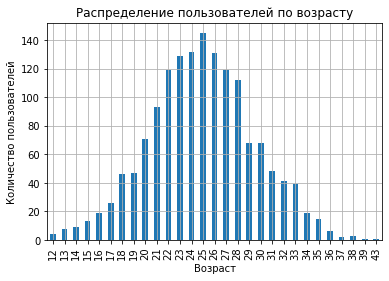

In [ ]:
users_df.groupby('age')['name'].count().plot(kind='bar', grid=True)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по возрасту');

Видим, что наибольшее число пользователей в возрасте 25 лет. Далее влево и вправо от данного числа следует убывание количества пользователей в зависимости от возраста, соответствующее нормальному распределению.

* Рассмотрим расстояние, которое преодолел пользователь за одну поездку, и продолжительность поездок.

In [ ]:
rides_df.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.660156,17.805012,6.486772
std,434.734317,1116.831177,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226318,13.597563,4.000000
50%,889.000000,3133.609985,17.678394,6.000000
75%,1213.250000,3776.222717,21.724800,9.000000
max,1534.000000,7211.007812,40.823963,12.000000


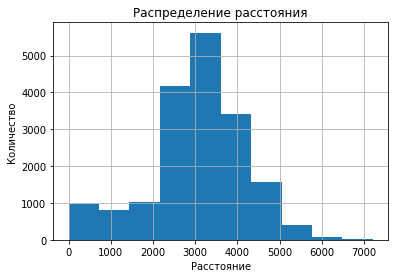

In [ ]:
rides_df['distance'].plot(kind='hist', grid=True)
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.title('Распределение расстояния');

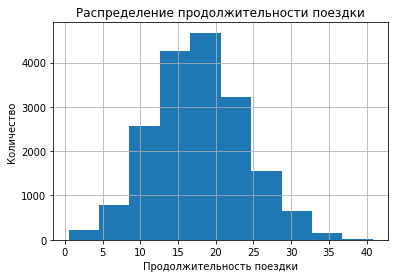

In [ ]:
rides_df['duration'].plot(kind='hist', grid=True)
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество')
plt.title('Распределение продолжительности поездки');

Из представленных данных можно сделать вывод, что среднее расстояние, которое преодолел пользователь за одну поездку равно ~3071 м, а средняя продолжительность при этом равна ~ 18 минут. Средние значения обоих столбцов не сильно отличаются от медианных, из чего можно сделать вывод, что в данных нет больших выбросов в ту или иную сторону.

UPD: по гистограммам можем увидеть, что распределение обоих параметров близко к нормальному, с пиком в районе среднего значения и симметричным убыванием в обе стороны.

#### Шаг 4. Объединение данных

* Объединим данные о пользователях, поездках и подписках в один датафрейм `df`. Рассмотрим получившийся датафрейм.

In [ ]:
df = users_df.merge(rides_df, on='user_id')
df = df.merge(subs_df, on='subscription_type')
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int32         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int32         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float32       
 6   duration           18068 non-null  float32       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int32         
 10  start_ride_price   18068 non-null  int32         
 11  subscription_fee   18068 non-null  int32         
dtypes: datetime64[ns](1), float32(2), int32(5), int64(1), object(3)
memory usage: 1.3+ MB


None

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.918945,25.599770,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592041,15.816872,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159790,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783203,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687256,26.265802,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890869,16.650139,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020264,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118164,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690674,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690674,15.041883,2021-11-22,11,6,0,199


На выходе мы получили датафрейм из 18068 строк и 12 столбцов. В процессе объединения никаких данных не потеряли.

* Создадим на основе полученной таблицы два датафрейма с информацией о пользователях с подпиской(`ultra_df`) и без(`free_df`).

In [ ]:
ultra_df = df.query('subscription_type == "ultra"')
display(ultra_df.info())
ultra_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int32         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int32         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float32       
 6   duration           6500 non-null   float32       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int32         
 10  start_ride_price   6500 non-null   int32         
 11  subscription_fee   6500 non-null   int32         
dtypes: datetime64[ns](1), float32(2), int32(5), int64(1), object(3)
memory usage: 482.4+ KB


None

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.918945,25.599770,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592041,15.816872,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159790,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783203,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687256,26.265802,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890869,16.650139,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020264,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118164,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690674,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690674,15.041883,2021-11-22,11,6,0,199


In [ ]:
free_df = df.query('subscription_type == "free"')
display(free_df.info())
free_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int32         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int32         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float32       
 6   duration           11568 non-null  float32       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int32         
 10  start_ride_price   11568 non-null  int32         
 11  subscription_fee   11568 non-null  int32         
dtypes: datetime64[ns](1), float32(2), int32(5), int64(1), object(3)
memory usage: 858.6+ KB


None

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690674,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932617,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434082,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911255,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379395,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002441,22.368010,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334961,18.243755,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551270,15.424898,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107178,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543945,11.312160,2021-06-23,6,8,50,0


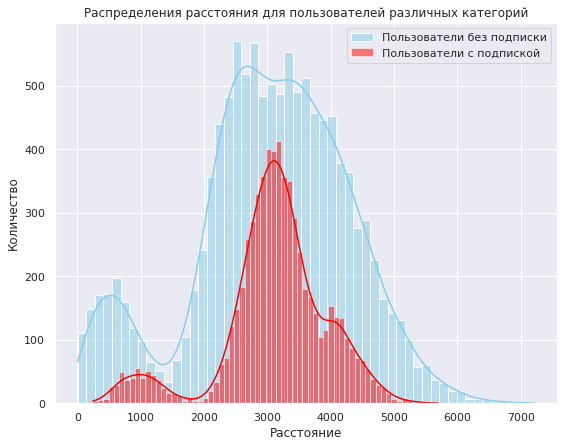

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(9, 7))

sns.histplot(data=free_df['distance'], color="skyblue", label="Пользователи без подписки", kde=True)
sns.histplot(data=ultra_df['distance'], color="red", label="Пользователи с подпиской", kde=True)

plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.title('Распределения расстояния для пользователей различных категорий')
plt.legend()
plt.show()

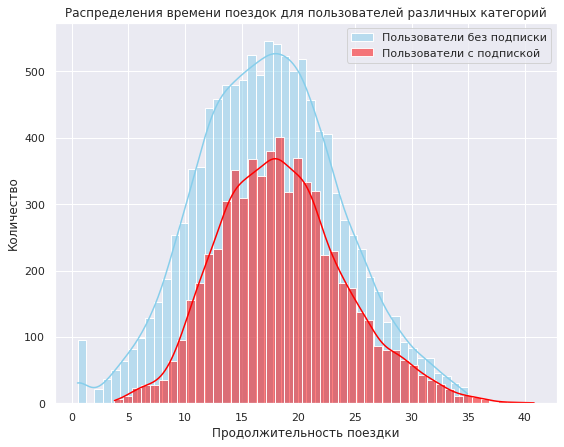

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(9, 7))

sns.histplot(data=free_df['duration'], color="skyblue", label="Пользователи без подписки", kde=True)
sns.histplot(data=ultra_df['duration'], color="red", label="Пользователи с подпиской", kde=True)

plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество')
plt.title('Распределения времени поездок для пользователей различных категорий')
plt.legend()
plt.show()

Из графиков видим, что распределение расстояния и времени поездок близко к нормальному, при этом количество пользователей без подписки в обоих случаях больше, чем пользователей с подпиской. Среднее значение расстояния и времени поездки у пользователей с подпиской несколько больше, чем у пользователей без неё.

#### Шаг 5. Подсчёт выручки

* Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными, включающий в себя суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [ ]:
df['duration'] = np.ceil(rides_df['duration'])
revenue_df = df.pivot_table(index=['subscription_type', 'user_id', 'month'],
                            values=['distance', 'duration', 'start_ride_price', 'minute_price', 'subscription_fee'],
                            aggfunc={'distance' : ['sum', 'count'], 'duration' : 'sum', 'start_ride_price' : 'first', 'minute_price' : 'first', 'subscription_fee' : 'first'})
revenue_df.reset_index(inplace= True )
revenue_df.columns = [(tup[0]+'_'+ tup[1]) if tup[1] else tup[0] for tup in revenue_df.columns]
revenue_df = revenue_df.rename(columns={'distance_count' : 'count'})
revenue_df.head(10)

,subscription_type,user_id,month,count,distance_sum,duration_sum,minute_price_first,start_ride_price_first,subscription_fee_first
0,free,700,1,1,2515.690674,15.0,8,50,0
1,free,700,2,5,13446.660156,89.0,8,50,0
2,free,700,3,1,3798.334961,19.0,8,50,0
3,free,700,4,1,2984.551270,16.0,8,50,0
4,free,700,6,2,5927.651367,29.0,8,50,0
5,free,700,7,2,4399.206055,21.0,8,50,0
6,free,700,8,1,4071.654785,17.0,8,50,0
7,free,700,10,2,6322.578613,44.0,8,50,0
8,free,700,11,3,8735.783203,32.0,8,50,0
9,free,701,1,1,2676.472900,18.0,8,50,0


In [ ]:
def revenue_per_month(row):
    if row['subscription_type'] == 'free':
        return (row['start_ride_price_first'] * row['count'] +
        row['minute_price_first'] * row['duration_sum'] + row['subscription_fee_first'])
    else:
        return (row['start_ride_price_first'] * row['count'] +
        row['minute_price_first'] * row['duration_sum'] + row['subscription_fee_first'])

revenue_df['rev_per_month'] = revenue_df.apply(revenue_per_month, axis=1)
revenue_df.head(10)

,subscription_type,user_id,month,count,distance_sum,duration_sum,minute_price_first,start_ride_price_first,subscription_fee_first,rev_per_month
0,free,700,1,1,2515.690674,15.0,8,50,0,170.0
1,free,700,2,5,13446.660156,89.0,8,50,0,962.0
2,free,700,3,1,3798.334961,19.0,8,50,0,202.0
3,free,700,4,1,2984.551270,16.0,8,50,0,178.0
4,free,700,6,2,5927.651367,29.0,8,50,0,332.0
5,free,700,7,2,4399.206055,21.0,8,50,0,268.0
6,free,700,8,1,4071.654785,17.0,8,50,0,186.0
7,free,700,10,2,6322.578613,44.0,8,50,0,452.0
8,free,700,11,3,8735.783203,32.0,8,50,0,406.0
9,free,701,1,1,2676.472900,18.0,8,50,0,194.0


Добавили столбец с помесячной выручкой, которую принёс каждый пользователь.

#### Шаг 6. Проверка гипотез

* Проверим гипотезу: тратят ли пользователи с подпиской больше времени на поездки?
    
    Для этого за нулевую гипотезу примем, что пользователи с подпиской и без тратят одинаковое время, за алтернативную гипотезу - пользователи с подпиской тратят больше времени на поездки.
    `mean_t_ultra` =  среднее время на поезду, которые тратят пользователи с подпиской, `mean_t_free` = среднее время на поезду, которые тратят пользователи без подписки
    
    H<sub>0</sub>: `mean_t_ultra` = `mean_t_free`
    
    H<sub>1</sub>: `mean_t_ultra` > `mean_t_free`
    
    Уровень статистической значимости примем равный 5%.
   

In [ ]:
print('Среднее значение продолжительности поездки для пользователей без подписки:', free_df['duration'].mean())
print('Среднее значение продолжительности поездки для пользователей с подпиской:', ultra_df['duration'].mean())
alpha = 0.05
results = st.ttest_ind(ultra_df['duration'], free_df['duration'], alternative='greater')

display(results.pvalue)

results.pvalue < alpha

Среднее значение продолжительности поездки для пользователей без подписки: 17.39091
Среднее значение продолжительности поездки для пользователей с подпиской: 18.541986


1.2801722407147585e-34

True

P-value меньше уровня статистической значимости, значит мы отвергаем нулевую гипотезу в пользу альтернативной. Пользователи с подпиской действительно тратят больше времени на поездки, чем пользователи без неё, это также видно и по среднему значению.

* Проверим гипотезу:  можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

    За нулевую гипотезу примем равенство расстояния, которое проезжают пользователи с подпиской за одну поездку, 3130 метрам. За альтернативную - данное значение больше 3130 метров.
    
    H<sub>0</sub>: `ultra_df['distance']` = 3130
    
    H<sub>1</sub>: `ultra_df['distance']` > 3130
    
    Уровень статистической значимости примем равный 5%.

In [ ]:
x = 3130
alpha = 0.05
results = st.ttest_1samp(ultra_df['distance'], x, alternative='greater')

display(results.pvalue)

results.pvalue < alpha

0.9195344662352914

False

Значение p-value больше уровня статистической значимости, значит мы не отвергаем нулевую гипотезу. Пользователи с подпиской проезжают в среднем за одну поездку не более 3130 метров.

* Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

    За нулевую гипотезу примем, что помесячная выручка пользователей с подпиской по месяцам равна помесячной выручки пользователей без подписки, за алтернативную - пользователи с подпиской приносят больше выручки по месяцам, чем пользователи без нее.
    
    H<sub>0</sub>: `mean_rev_ultra` = `mean_rev_free`
    
    H<sub>1</sub>: `mean_rev_ultra` > `mean_rev_free`
    
    Уровень статистической значимости примем равный 5%.
   

In [ ]:
print('Среднее значение выручки для пользователей без подписки:',
      revenue_df.query('subscription_type == "free"')['rev_per_month'].mean())
print('Среднее значение выручки для пользователей с подпиской:',
      revenue_df.query('subscription_type == "ultra"')['rev_per_month'].mean())
alpha = 0.05
results = st.ttest_ind(revenue_df.query('subscription_type == "ultra"')['rev_per_month'],
                         revenue_df.query('subscription_type == "free"')['rev_per_month'],
                         alternative='greater')
display(results.pvalue)
results.pvalue < alpha

Среднее значение выручки для пользователей без подписки: 328.6413651073845
Среднее значение выручки для пользователей с подпиской: 362.7921906022502


1.8850394384715216e-31

True

P-value меньше альфа, значит отвергаем нулевую гипотезу. Пользователи с подпиской в среднем по месяцам приносят больше выручки, чем пользователи без.

* Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В денном примере представлена гипотеза о равенстве средних для зависимых (парных) выборок. Для нее понадобится тест Стьюдента, описанный в Python методом `scipy.stats.ttest_rel`. В данном случае нулевая гипотеза гласит, что количество обращений после обновления равно количеству обращений до, альтернативная - количество обращений после обновления уменьшилось. Нам необходимо провести проверку правосторонней альтернативной гипотезы о том, что истинное среднее генеральной совокупности до изменения больше, чем истинное среднее генеральной совокупности после изменения.

#### Шаг 7. Распределения

* Подобрать параметры распределения, описывающего ситуацию из задания 7.1, построить график распределения и выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


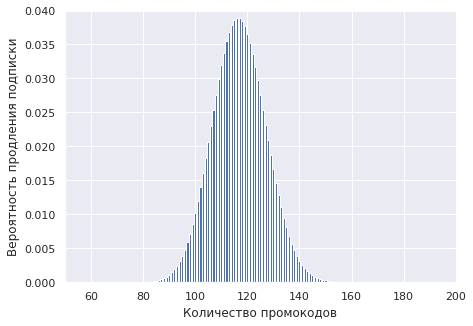

In [ ]:
n = 1168
p = 0.1

distr = []

# построим биномиальное распределение
for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)

plt.figure(figsize=(7, 5))
plt.grid(True)
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность продления подписки')
plt.axis([50, 200, 0, 0.04])
plt.bar(range(0, n + 1), distr);

In [ ]:
# Зададим параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# теперь само нормальное распределение
distr = st.norm(mu, sigma)

# Посчитаем вероятность получить значение от 0 до 100.
result = distr.cdf(100) - distr.cdf(0)
result

0.050650790692463

В результате подбора значения `n` получили, что для того, чтобы как минимум 100 клиентов продлили подписку с вероятностью не выполнить план около 5%, необходимо раздать 1168 промокодов. Т.к. значение `p` достаточно маленькое, необходимо было сильно увеличить `n` для заданного процента успеха.

* Постром примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей для параметров, представленных в пункте 7.2 задания.

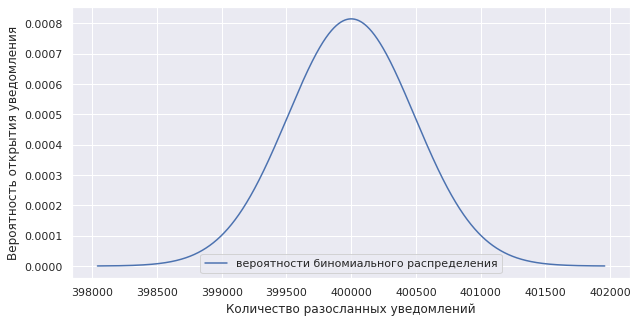

In [ ]:
n = 1000000
p = 0.4

# определим границы, в которых будем строить аппроксимацию
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# зададим набор значений биномиальной величины на выбранном промежутке
x = list(range(max(0, left), right))

# построим график биномиального распределения
plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.grid(True)
plt.xlabel('Количество разосланных уведомлений')
plt.ylabel('Вероятность открытия уведомления')
ax.plot(x, st.binom.pmf(x, n, p), label='вероятности биномиального распределения')
ax.legend(loc='best')
plt.show()

Считаем вероятность получить значение от 0 до 399,5 тыс.

In [ ]:
# Зададим параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# теперь само нормальное распределение
distr = st.norm(mu, sigma)

# Посчитаем вероятность получить значение от 0 до 399,5 тыс.
result = distr.cdf(399500) - distr.cdf(0)
result

0.15371708296369768

Построили примерный аппроксимированный график распределения. выяснили, что вероятность того, что уведомление откроют не более
399,5 тыс. пользователей равна ~15,37%.

#### Общий вывод

**Вывод:** открыли и изучили таблицы с данными.

Первый датафрейм, содержащий информацию о пользователях, состоит из 5 столбцов и 1565 строк, тип данных в которых: int64 (2 столбца) и object(3 столбца).

Второй датафрейм, который содержит информацию о поездках, состоит из 4 столбцов и 18068 строк, тип данных в которых: int64 (1 столбец), float64 (2 столбца) и object(1 столбец).

Третий датафрейм с информацией о подписках, состоит из 4 столбцов и всего 2-х строк, тип данных в которых: int64 (3 столбца) и object(1 столбец).

Данные представлены с 01.01.2021 по 30.12.2021, промежуток составляет 363 дня, практически весь 2021-й год.

Изменили тип данных в столбце `date`, создали новый столбец с номером месяца. Для экономии памяти заменили 64-х разрядные числовые переменные на 32-х разрядные. Обнаружили, что пропуски в представленных датафреймах отсутствуют. Таблица `users_df` имела 31 явный дубликат, избавились от них, после чего число строк в ней стало равняться 1534. Больше явных дубликатов обнаружено не было, во всех оставшихся колонках первых двух датафреймов повторение значений нормально для представленных данных, мы не можем называть это неявными дубликатами.

Далее провели исследовательский анализ данных, в ходе которого орпеделили:

1. Пользователи практически равнромерно распределены по городам. При этом наиболее часто встречается город Пятигорск, наименее часто - Москва.
2. Количество пользователей без подписки от общего числа пользователей составляют 54,4% , с подпиской - 45,6%.
3. Наибольшее число пользователей в возрасте 25 лет. Далее влево и вправо от данного числа следует убывание количества пользователей в зависимости от возраста, соответствующее нормальному распределению.
4. Среднее расстояние, которое преодолел пользователь за одну поездку равно ~3071 м, а средняя продолжительность при этом равна ~ 18 минут. Средние значения обоих столбцов не сильно отличаются от медианных, из чего можно сделать вывод, что в данных нет больших выбросов в ту или иную сторону. Распределение обоих параметров близко к нормальному, с пиком в районе среднего значения и симметричным убыванием в обе стороны.

Объединили данные о пользователях, поездках и подписках в один датафрейм. Создайли ещё два датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской. Определили, что распределение расстояния и времени поездок близко к нормальному, при этом количество пользователей без подписки в обоих случаях больше, чем пользователей с подпиской, при этом среднее значение расстояния и времени поездки у пользователей с подпиской несколько больше, чем у пользователей без неё.

Создали датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными, включающий в себя суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. После чего добавили в него столбец с помесячной выручкой, которую принёс каждый пользователь.

Проверили гипотезы и пришли к следующим выводам:
 * Пользователи с подпиской тратят больше времени на поездки, чем пользователи без неё.
 * Пользователи с подпиской проезжают в среднем за одну поездку не более 3130 метров, что оптимально для уровня износа самоката.
 * Пользователи с подпиской в среднем по месяцам приносят больше выручки, чем пользователи без.

Можно сделать вывод, о необходимости увеличения доли пользователей с подпиской, т.к. они приносят больше выручки, но при этом оптимально используют самокат с точки зрения износа. Для этого можно проводить акции и рассылки, как в заданиях пункта 7, где для успешного привлечения клиентов необходимо либо увеличивать количество потенциальных клиентов, либо увеличивать вероятность их подписки по результатам той или иной промоакции.